# Synopsis

# Configuration

In [1]:
data_dir = '/home/rca2t/Public/ETA/data/'
OHCO = ['title_id', 'chap_num', 'para_num', 'token_num', 'sent_num']

In [2]:
vocab_weight = 'term_count'
vocab_weight_quantile = .94
vocab_min_n = 3
kde_kernel = 'gaussian'
kde_bandwidth = 2000
kde_samples = 1000

# Libraries

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.neighbors import KernelDensity as KDE
from nltk.corpus import stopwords

# Pragmas

In [4]:
from IPython.display import display, HTML

In [5]:
%matplotlib inline
%pwd

'/sfs/qumulo/qhome/rca2t/Public/ETA/notebooks/MOD02--TextModels'

# Functions

In [6]:
def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

# Process

## Import tables from database

In [7]:
V = pd.read_csv(data_dir+'/austen-vocab.csv')
K0 = pd.read_csv(data_dir+'/austen-tokens.csv', index_col=OHCO)

In [8]:
K = K0.loc[(0)]
K = K.reset_index(drop=True)
K.index.name = 'offset'

In [9]:
K.head()

,token_str,term_str,term_id
offset,,,
0,Sir,sir,11838
1,Walter,walter,14184
2,Elliot,elliot,4360
3,of,of,8866
4,Kellynch,kellynch,7404


## Reduce vocabulary 

In [10]:
stops = set(stopwords.words('english'))

In [11]:
len(stops)

179

In [12]:
V1 = V[(~V.term_str.isin(stops)) & (V.term_count < 1000) & (V.term_count > 100)]

In [13]:
V1.shape

(683, 5)

In [14]:
V1.sort_values('term_count', ascending=False).head(10)

,term_id,term_str,term_count,tf,len
5053,5053,fanny,978,0.001242,5
3254,3254,dear,960,0.001219,4
13417,13417,two,947,0.001202,3
11614,11614,shall,943,0.001197,5
4721,4721,ever,936,0.001188,4
7983,7983,man,928,0.001178,3
11838,11838,sir,924,0.001173,3
11840,11840,sister,909,0.001154,6
10308,10308,quite,908,0.001153,5
7933,7933,made,891,0.001131,4


In [15]:
K = K[K.term_str.isin(V1.term_str)]

In [16]:
K.head()

,token_str,term_str,term_id
offset,,,
0,Sir,sir,11838
1,Walter,walter,14184
2,Elliot,elliot,4360
10,man,man,7983
17,took,took,13167


## Create arrays of offsets for each term

In [17]:
B = K.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()

In [18]:
B['x'] = B.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)

In [19]:
B.head()

,offset,x
term_str,,
able,"[2488, 3121, 11335, 12071, 13981, 15029, 16923...","[[2488], [3121], [11335], [12071], [13981], [1..."
absence,"[10229, 10842, 16082, 23652, 35418, 68485, 709...","[[10229], [10842], [16082], [23652], [35418], ..."
absolutely,"[10657, 28814, 56690, 69736, 83932]","[[10657], [28814], [56690], [69736], [83932]]"
account,"[6359, 11266, 11507, 11630, 11683, 12150, 1672...","[[6359], [11266], [11507], [11630], [11683], [..."
acquaintance,"[692, 1219, 1633, 1891, 2911, 8246, 9276, 1252...","[[692], [1219], [1633], [1891], [2911], [8246]..."


## Get KDE for each term

In [20]:
scale_max = K.index.max() # THIS IS CRUCIAL
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)
# B['scaled'] = B.apply(lambda row: np.exp(row.scores) * (scale_max / kde_samples), axis=1)

## Visualize KDE plots

In [21]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)

In [22]:
FIG = dict(figsize=(15, 5))

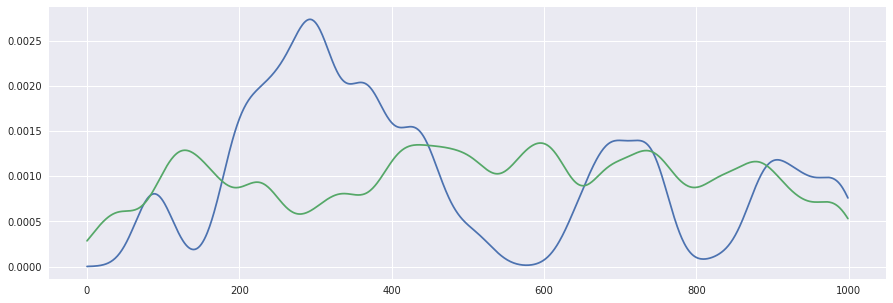

In [23]:
PLOTS.loc['wentworth'].plot(**FIG)
PLOTS.loc['anne'].plot(**FIG)

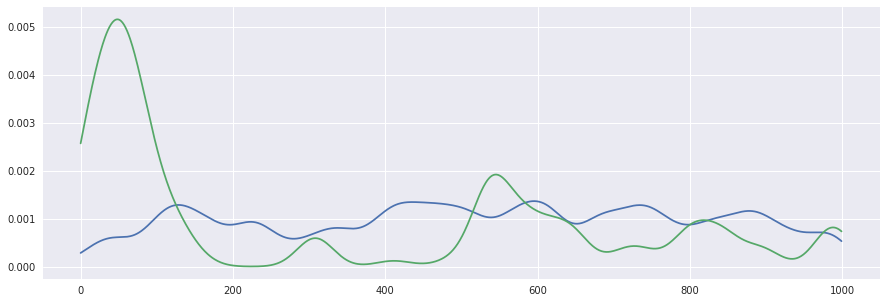

In [26]:
PLOTS.loc['anne'].plot(**FIG)
PLOTS.loc['walter'].plot(**FIG)

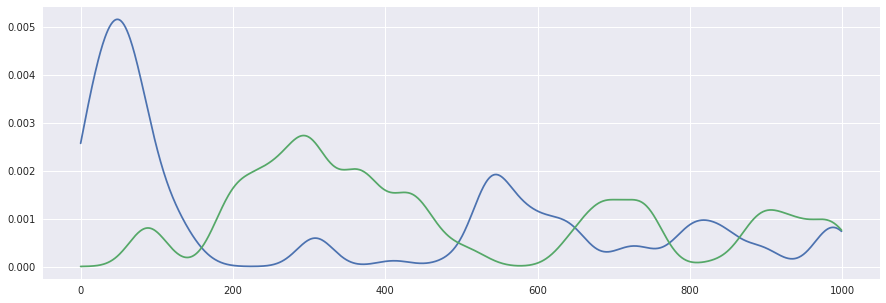

In [27]:
PLOTS.loc['walter'].plot(**FIG)
PLOTS.loc['wentworth'].plot(**FIG)

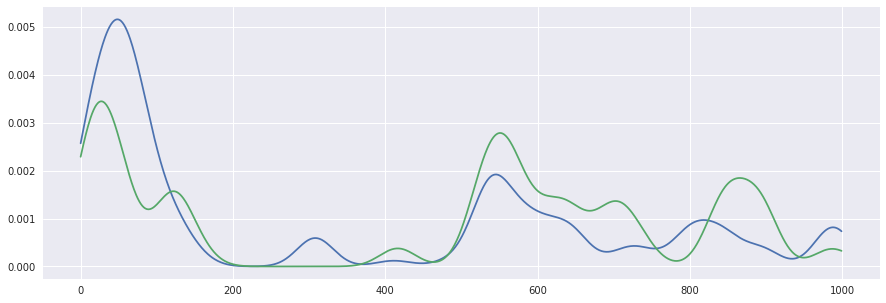

In [25]:
PLOTS.loc['walter'].plot(**FIG)
PLOTS.loc['elizabeth'].plot(**FIG)

## Score Pairs

We generate only unique combinations of pairs not permutation, i.e. we treat `a,b == b,a`.

In [28]:
pairs = pd.DataFrame([(x,y) for x in B.index for y in B.index if y > x] , columns=['x','y'])

In [29]:
pairs.head(10).T

,0,1,2,3,4,5,6,7,8,9
x,able,able,able,able,able,able,able,able,able,able
y,absence,absolutely,account,acquaintance,acquainted,act,added,admiral,admiration,advantage


## Compute overlap

This takes a while to run.

In [30]:
def overlap(row):
    kde1 = PLOTS.loc[row.x]
    kde2 = PLOTS.loc[row.y]
    overlap = np.minimum(kde1, kde2)
    return np.trapz(overlap)

In [31]:
pairs['overlap'] = pairs.apply(overlap, axis=1)

In [32]:
def paircorr(row):
    return PLOTS.T[[row.x,row.y]].corr().values[0][1]

In [33]:
pairs['corr'] = pairs.apply(paircorr, axis=1)

## Skim Top Pairs

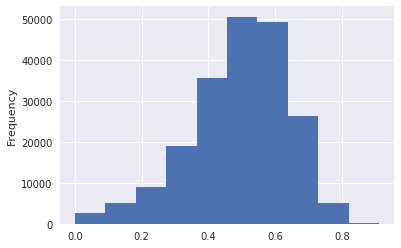

In [34]:
pairs.overlap.plot.hist()

In [35]:
pairs[pairs.overlap > .6 ].sort_values('overlap', ascending=False)

,x,y,overlap,corr
76907,dearest,frank,0.910901,0.986687
157428,looking,many,0.896010,0.867171
32555,away,however,0.876849,0.737618
193616,sir,walter,0.868542,0.986776
124533,give,perfectly,0.864987,0.601432
112178,feeling,many,0.861719,0.739102
19249,anne,yet,0.859953,0.614545
18893,anne,however,0.858343,0.506352
160001,make,thought,0.856553,0.387522
126321,going,gone,0.856533,0.729126


In [36]:
pairs2 = pairs.copy().rename(columns={'x':'y', 'y':'x'})
pairs3 = pd.concat([pairs, pairs2], sort=True)

## See related terms for top terms

In [45]:
# TOP_TERMS = V1.iloc[40:60].term_str.tolist()
TOP_TERMS = 'anne wentworth elliot elizabeth'.split()

In [46]:
TOP_TERMS

['anne', 'wentworth', 'elliot', 'elizabeth']

In [47]:
DETAIL = '<table>'
for i, term in enumerate(TOP_TERMS):
    friends = pairs3[pairs3.x == term].sort_values('overlap', ascending=False).head(10)
    DETAIL += "<tr><td colspan=1><b>{}. {}</b></td></tr>".format(i+1, term)
    for row in friends.reset_index(drop=True)[['y', 'overlap']].values:
        bar = round(row[1] * 100) * '|'
        DETAIL += "<tr><td>{}</td><td style='text-align:left;'>{} ({})</td></tr>".format(row[0], bar, row[1])
DETAIL += "</table>"

In [48]:
display(HTML(DETAIL))

## Explore term correlations

In [49]:
CORR = pd.crosstab(pairs3.x, pairs3.y, pairs3.overlap, aggfunc='sum').fillna(1)

In [50]:
CORR.head()

y,able,absence,absolutely,account,acquaintance,acquainted,act,added,admiral,admiration,...,worth,write,written,wrong,year,years,yes,yesterday,yet,young
x,,,,,,,,,,,,,,,,,,,,,
able,1.000000,0.524566,0.353810,0.723630,0.663432,0.593096,0.339930,0.549062,0.397966,0.457750,...,0.456841,0.498892,0.417986,0.319828,0.387854,0.569432,0.609062,0.550299,0.669399,0.636705
absence,0.524566,1.000000,0.461409,0.553238,0.291594,0.426282,0.428588,0.495119,0.331120,0.493399,...,0.197061,0.354372,0.400766,0.513005,0.399864,0.440828,0.541361,0.494077,0.480064,0.543568
absolutely,0.353810,0.461409,1.000000,0.413621,0.312572,0.396114,0.334564,0.406716,0.431802,0.342216,...,0.248880,0.275980,0.388365,0.381216,0.379442,0.296685,0.462528,0.430482,0.473932,0.472678
account,0.723630,0.553238,0.413621,1.000000,0.636613,0.614106,0.331717,0.607060,0.428082,0.502256,...,0.507791,0.433033,0.369799,0.389034,0.441645,0.614179,0.691674,0.541036,0.769305,0.690290
acquaintance,0.663432,0.291594,0.312572,0.636613,1.000000,0.635630,0.332559,0.550906,0.422470,0.316908,...,0.641765,0.395267,0.392616,0.222971,0.406202,0.629845,0.614430,0.482689,0.648926,0.543396


In [51]:
def corr_plot_terms(terms, dtm, title='Foo'):
    plt.figure(figsize = (20,20))
    print(title)
    corr = dtm[terms].corr()
    sns.heatmap(corr, vmax=.3, annot=True, center=0, 
              cmap='RdYlGn',
              square=True, linewidths=.5, 
              cbar_kws={"shrink": .5})
    plt.show()

TEST


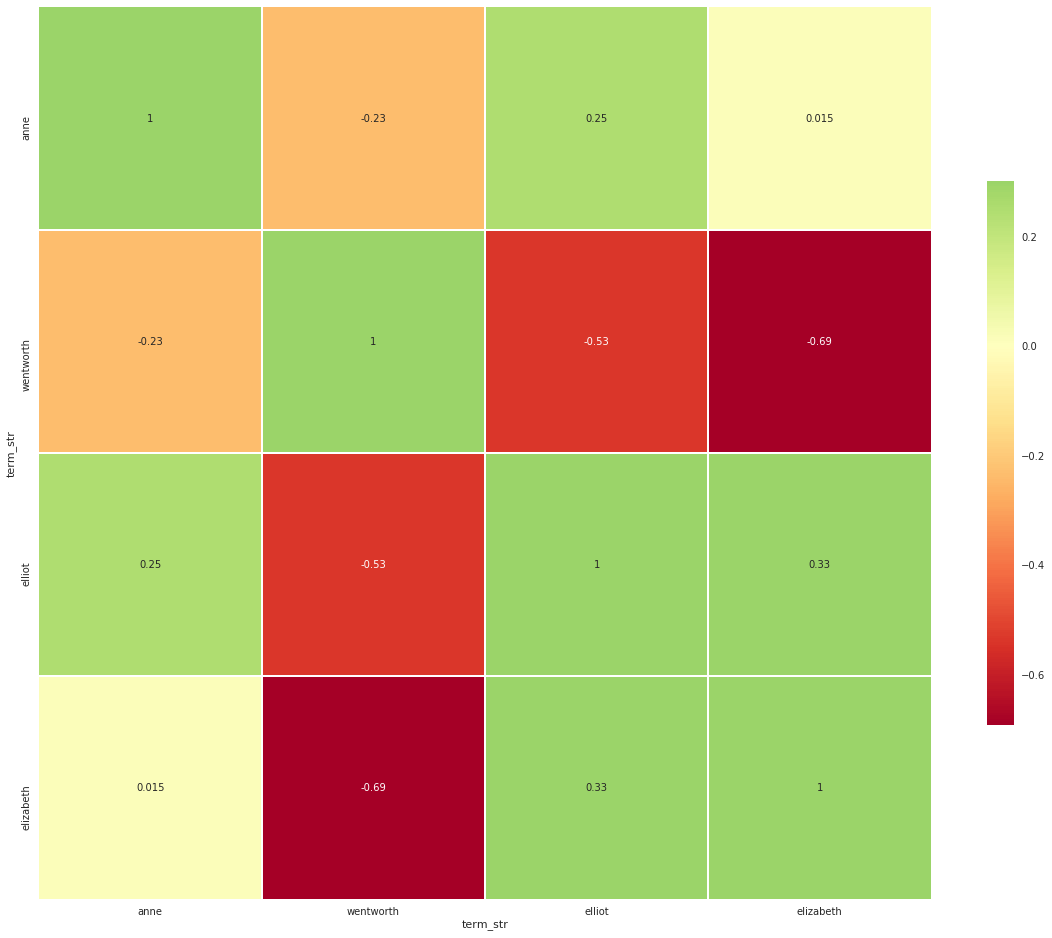

In [52]:
corr_plot_terms(TOP_TERMS, PLOTS.T, title='TEST')

## Export Graphs

In [54]:
import networkx as nx
G = nx.Graph()
edges = pairs[['x','y','overlap']].sort_values('overlap', ascending=False).head(1000).apply(lambda x: (x.x, x.y, x.overlap), axis=1).values
G.add_weighted_edges_from(edges)
nx.write_gexf(G, "{}.gexf".format('austen'))

# Save

In [ ]:
pairs.to_csv(data_dir + '/austen-persuasion-term_pairs.csv')
PLOTS.T.to_csv(data_dir + '/austen-persuasion-term_kde.csv')